In [41]:
from time import process_time
import matplotlib.pyplot as plt
import scipy
import psutil

from qutip import *

from scipy.sparse import load_npz, save_npz
from scipy import signal

import numpy as np
from numpy import linalg as LA

# Common definitionsdef gauss(x, x_0, sigma):
    return 1*np.exp(-((x-x_0) / sigma) ** 2)

In [4]:
def gauss(x, x_0, sigma):
    return 1*np.exp(-((x-x_0) / sigma) ** 2)

In [593]:
# Model description
# Units in kHz
# /2pi

gk = 1.6 # kHz Coupling strength
kappa = 160. # kHz Cavity linewidth
gamma = 2000.
Gamma = 0. # Dephasing

N_spin = 1e2 # Total number of emitters
N_cav = 30 # Fock states
k = 1 # Number of frequency classes
delta_c = 0. # wc-wp
sigma_c = 10.*kappa # Broadening STD

Delta_max = 5.*sigma_c
# delta_a = np.linspace(-Delta_max, Delta_max, k) # Spin inhomogenous broadening span
delta_a = 0.001*sigma_c
norm = np.sum(gauss(delta_a, 0, sigma_c))
ki = gauss(delta_a, delta_c, sigma_c)/norm*Ne # Population distribution for each class 

# Square pulse
dt = 1/10.*1/gamma
endtime = 10/gk
intervals = int(endtime/dt)
tlist = np.linspace(0, endtime, intervals)
tprep = 0.2 #us*endtime
F = 0. #kHz
Ft = np.append(np.ones(int(intervals*tprep)), np.zeros(int(intervals*(1-tprep))))
# Ft = np.zeros(intervals)

w_spin = delta_a - 1j*(gamma/2. + Gamma)
w_cav = delta_c - 1j*kappa/2.

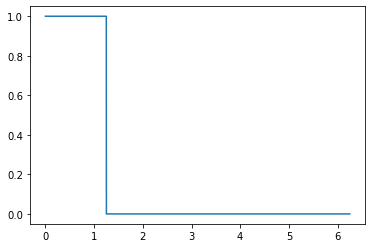

In [469]:
plt.plot(tlist, Ft)

# QuTiP

## Exact Solution

In [349]:
def ind_op(op1, op2, N_spin, index):
    # create a tensor product of op1 everywhere but at index, where it's op2
    # returns tensor_i!=index op1 tensor op2
    a = [op1] * N_spin
    a[index] = op2
    return tensor(a)

def sum_ops(op1, op2, N_spin, c):
    # sum of all permutations where all operators are op1 but one is op2
    return sum([c*ind_op(op1, op2, N_spin, i) for i in range(N_spin)])

In [595]:
%%time
# Operators and Hamiltonian
# Fock states
Nmax = 5
n_ex = np.zeros((Nmax, intervals))
n_cav = np.zeros((Nmax, intervals))
for i in range(4,5):
    Nk = i+1
    i_emi = tensor([qeye(2)]*Nk)
    psi0 = tensor(basis(N, 0), tensor([basis(2, 0)]*Nk)) # (2,0) excited
    a = tensor(destroy(N), i_emi)
    ad = tensor(destroy(N).dag(),i_emi)
    sp = tensor(qeye(N), sum_ops(qeye(2), sigmap(), Nk, 1))
    sm = tensor(qeye(N), sum_ops(qeye(2), sigmam(), Nk, 1))
    sz = tensor(qeye(N), sum_ops(qeye(2), sigmaz(), Nk, 1))
    
    # Operators may not be correct: [S^2, Sz]=0, need to take into account that they are permutational invariant
    H0 = delta_c*ad*a + delta_a/2*sz + gk*(a*sp + ad*sm)
    H = [H0, [F*(ad+a), Ft]]
    output = mesolve(H, psi0, tlist, c_ops = [], e_ops=[(Nk+sz)/2., ad*a])
    print('N_spin = ', i+1)
    n_ex[i] = output.expect[0]
    n_cav[i] = output.expect[1]

N_spin =  5
CPU times: user 16.3 s, sys: 120 ms, total: 16.4 s
Wall time: 16.4 s


Text(0.5, 0, 'Time in us')

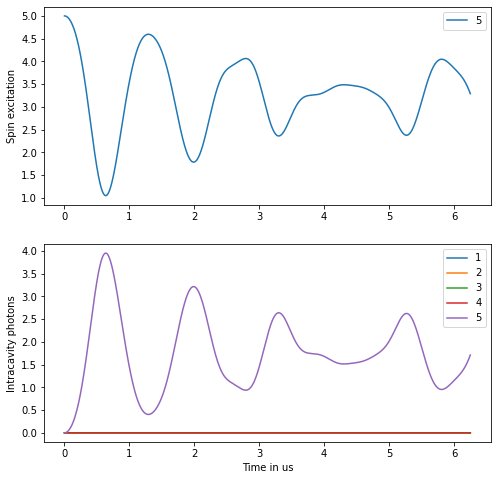

In [596]:
end = -1
fig, ax = plt.subplots(2, 1, figsize=(8,8))
for i in range(4,5):
    ax[0].plot(tlist, n_ex[i], label = i+1)
for i in range(Nmax):
    ax[1].plot(tlist, n_cav[i], label = i+1)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Spin excitation')
ax[1].set_ylabel('Intracavity photons')
ax[1].set_xlabel('Time in us')
#plt.plot(tlist, output.expect[1], label = 'population in cavity')

In [592]:
F

3000.0

## Permutational-invariant PIQS

In [372]:
from qutip.piqs import *

In [573]:
%%time
n_ex_piq = np.zeros((Nmax, intervals))
n_cav_piq = np.zeros((Nmax, intervals))
for i in range(5):
    # Two level system setup
    N_spin = i+1
    nds = num_dicke_states(N_spin)
    [jx, jy, jz] = jspin(N_spin)
    jp, jm = jspin(N_spin, "+"), jspin(N_spin, "-")
    gE = gamma
    # Spin hamiltonian
    H_spin = delta_a/2 * jz
    # Spin liouvillian
    spins = Dicke(N=N_spin, hamiltonian=H_spin, emission=0.0)
    liouv_spin = spins.liouvillian()

    # Cavity
    N_cav = 20
    a = destroy(N_cav)
    # Cavity hamiltonian
    H_cav = delta_c * a.dag() * a
    liouv_cav = liouvillian(H_cav)
    
    # System super operators
    id_spin = to_super(qeye(nds))
    id_cav = to_super(qeye(N_cav))
    jz_tot = tensor(qeye(N_cav), jz)
    jm_tot = tensor(qeye(N_cav), jm)
    jpjm_tot = tensor(qeye(N_cav), jp*jm)
    a_tot = tensor(a, qeye(nds))
    ada_tot = tensor(a.dag()*a, qeye(nds))
    bas_ex = excited(N_spin, basis='dicke')
    bas_gd = ground(N_spin, basis='dicke')
    psi0 = tensor(fock_dm(N_cav,0), bas_ex)
    #H_pump = QobjEvo([F*(a_tot.dag()+a_tot), Ft], tlist=tlist)

    # Interaction hamiltonian
    H_int = gk * (a_tot.dag()*jm_tot + a_tot*jm_tot.dag())
    # Total liouvillian
    liouv_int = liouvillian(H_int)
    liouv_tot = super_tensor(liouv_cav, id_spin) + super_tensor(id_cav, liouv_spin) + liouv_int
    output = mesolve(liouv_tot, psi0, tlist, e_ops = [jz_tot+N_spin/2.,ada_tot])
    print('N_spin = ', N_spin)
    n_ex_piq[i] = output.expect[0]
    n_cav_piq[i] = output.expect[1]

N_spin =  1
N_spin =  2
N_spin =  3
N_spin =  4
N_spin =  5
CPU times: user 5min 49s, sys: 1min 55s, total: 7min 45s
Wall time: 1min 55s


In [571]:
liouvillian(H_pump)

Text(0.5, 0, 'Time in us')

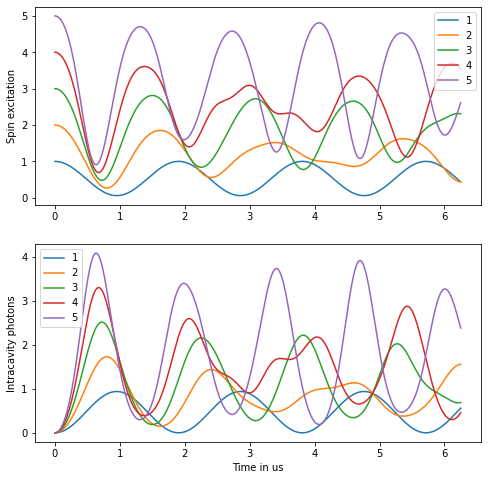

In [575]:
end = -1
fig, ax = plt.subplots(2, 1, figsize=(8,8))
for i in range(Nmax):
    ax[0].plot(tlist, (n_ex_piq[i]), label = i+1)
for i in range(Nmax):
    ax[1].plot(tlist, n_cav_piq[i], label = i+1)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Spin excitation')
ax[1].set_ylabel('Intracavity photons')
ax[1].set_xlabel('Time in us')
#plt.plot(tlist, output.expect[1], label = 'population in cavity')

In [461]:
expect((jz_tot+Nk)/2.,tensor(fock_dm(N,0), bas_gd))

1.25

In [460]:
N

20

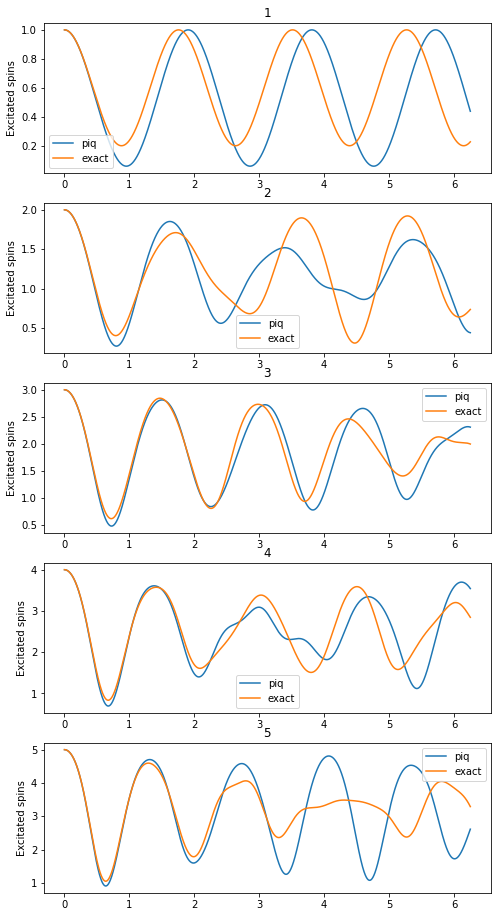

In [586]:
fig, ax = plt.subplots(5,1, figsize=(8,16))
for i in range(5):    
    ax[i].plot(tlist, n_ex_piq[i], label = 'piq')
    ax[i].plot(tlist, n_ex[i], label = 'exact')
    ax[i].legend()
    ax[i].set_ylabel('Excitated spins')
    ax[i].set_title(i+1)